#### Train scikit-learn GBM algorithm locally on SageMaker Notebook

Automatically created module for IPython interactive environment
MSE: 6.5290


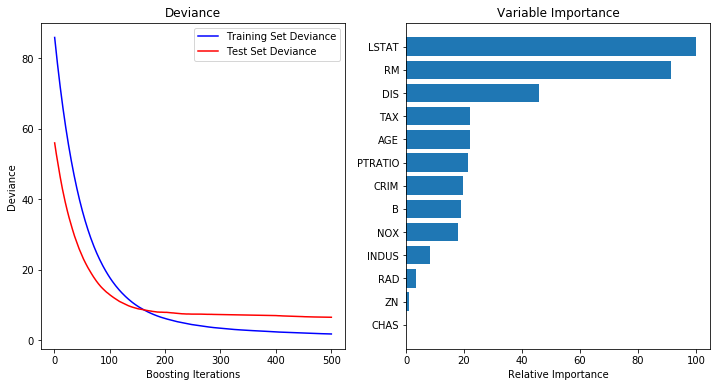

In [92]:
%matplotlib inline

print(__doc__)

# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Load data
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Save the trained model

In [125]:
import pickle

filename = 'model.pkl'
pickle.dump(clf, open(filename, 'wb'))

#### Initialize SageMaker Session

In [126]:
import sagemaker as sage
from time import gmtime, strftime
from sagemaker import get_execution_role
from sagemaker.sklearn import SKLearnModel

bucket=<your s3 bucket>

role = get_execution_role()
sess = sage.Session()

#### Compress the model and upload to S3 bucket

In [127]:
!tar -czvf model.tar.gz model.pkl
prefix = 'scikit-gbm-pretrained/model'

model_location = sess.upload_data("model.tar.gz", bucket=bucket, key_prefix=prefix)
!rm model.tar.gz

model.pkl


#### Initialize the SageMaker Model using entrypoint file that provide model_fn, input_fn and output_fn. 

Refer to https://sagemaker.readthedocs.io/en/stable/using_sklearn.html#deploying-scikit-learn-models for details

In [135]:
!cat gbm_predictor_entrypoint.py

import pickle
import numpy as np
import os
import json
from io import StringIO
from six import BytesIO


def model_fn(model_dir):
    print("model_dir:{}".format(model_dir))
    with open(os.path.join(model_dir, 'model.pkl'), 'rb') as inp:
        clf = pickle.load(inp)
        return clf


def input_fn(request_body, request_content_type):
    
    print("request_content_type :{}".format(request_content_type))
    
    if request_content_type == 'text/csv':
        # Read the raw input data as CSV.
        npreq = np.genfromtxt(StringIO(request_body), delimiter=",")
        print ("shape of array:{}".format(npreq.shape))
        return npreq
    elif request_content_type == 'application/x-npy':
        return _npy_loads(request_body)
    else:
        raise ValueError("{} not supported by script!".format(request_content_type))


def output_fn(prediction, response_content_type):
    
    print("response_content_type :{}".format(response_content_type))
    
    if response_content_type =

In [128]:

model_name = 'sagemaker-scikit-learn-gbm-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
sklearn_model = SKLearnModel(model_data=model_location, 
                             role=role,
                             name=model_name,
                             entry_point="gbm_predictor_entrypoint.py")


#### Deploy the the model as SageMaker Endpoint

In [129]:
predictor = sklearn_model.deploy(instance_type="ml.t2.medium", initial_instance_count=1)

----------------------------------------------------------------------------------------------------!

#### Invoke Realtime Prediction

In [130]:
predictor.predict(X_test)

array([[15.45630765, 27.70431624, 24.15321751, 32.02075062, 10.42347915,
        34.46976482, 21.86262083, 11.44006935, 13.03124197, 43.01692715,
        33.00400493, 15.83309049, 23.89733528, 19.90679772, 25.21960401,
        20.89320822, 13.58174696, 47.50914601, 17.60704318, 21.45384545,
        22.45285259, 17.17153218, 16.41037479, 20.62238492, 14.51460491,
        11.89278985, 24.58936937, 37.71601241, 30.49305468, 19.9052818 ,
        23.1976153 , 25.22487082, 18.62201982, 30.43276044,  8.87693437,
        13.69622405, 14.3609829 , 17.45462645, 19.83528506, 23.63952077,
        20.30075508, 15.33379899, 25.82934672, 16.41125401, 19.17299686,
        19.88662721, 21.39655525, 21.78775451, 24.38255215, 22.37496426,
        22.32651597]])

### Batch Prediction
1. Save the Batch prediction input features(batch_input) to a CSV formatted file in S3
2. Define output location in S3 (batch_output) where predictions will be saved

In [ ]:
np.savetxt('batch_transform_input.csv', X_test, delimiter=',') 
prefix = 'scikit-gbm-pretrained/input'
out_prefix = 'scikit-gbm-pretrained/output'
batch_input = 's3://{}/{}'.format(bucket,prefix)
batch_output = 's3://{}/{}'.format(bucket,out_prefix)
sess.upload_data('batch_transform_input.csv', bucket=bucket, key_prefix=prefix)

#### Define Batch prediction Request. We will use boto3 python package to start batch transform job

Refer for more details https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_transform_job

In [132]:
batch_job_name = 'scikit-gbm-batch' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

request = \
{
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "BatchStrategy": "MultiRecord",
    "TransformOutput": {
        "S3OutputPath": batch_output,
        "Accept": "text/csv",
        "AssembleWith": "Line",
    },
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": batch_input 
            }
        },
        "ContentType": "text/csv",
        "SplitType": "Line",
        "CompressionType": "None"
    },
    "TransformResources": {
            "InstanceType": "ml.m4.xlarge",
            "InstanceCount": 1
    }
}

1. Create Batch prediction job
2. Wait for job to finish
3. Check Job run details in SageMaker console
4. Check output predictions in CSV file in Amazon S3

In [133]:
import boto3
import time
sm = boto3.client('sagemaker')

sm.create_transform_job(**request)
                            
while(True):
    response = sm.describe_transform_job(TransformJobName=batch_job_name)
    status = response['TransformJobStatus']
    if  status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed') 
    print("Transform job is still in status: " + status)    
    time.sleep(30) 

Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job is still in status: InProgress
Transform job ended with status: Completed
